### Prep Work

In [1]:
# Import general libraries
import pandas as pd
import numpy as np

import datetime
import warnings; warnings.simplefilter('ignore')

np.random.seed(42)

In [2]:
# Import NLP libraries
import re
import gensim

from gensim.models.word2vec import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [3]:
# Import Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Increase size of dataframe
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_rows', 100000)
pd.options.display.max_colwidth = 500

### Read clean historical maintenance data for ATA25 codes

In [5]:
data = pd.read_csv('./data/data_ata25.csv', index_col=0)

In [6]:
# ATA code should be an object with leading zeros
data['ata4_code'] = data['ata4_code'].astype(str).map(lambda x: x.zfill(4))

In [7]:
data.drop_duplicates;

In [8]:
data.shape

(10062, 8)

In [9]:
data.head(2)

,fleet,problem_log,corrective_action,delay_code,station_delay_minutes,d&c_category,ata4_code,ata4_desc
1432,A319-131,CREW REPORTED RUBBER SMELL IN CABIN F ROM ROWS 1 TO ROWS 21. NEWMAN TOMC. SAMC TEXT: WO#15092916. CREW ALSO REPORTED THAT SMELL HAD QUICK LY DISAPATED. NEWMAN TOMC.,":NO DEFECTS NOTED IN GALLEY EQUIP, CABIN EQUIP, AEVC EQUIP AND AIR COND EQUIP PER TSM 05-51-00. FO LLOWED TSM 21-00-00-810-801 PERFORMED ENG AND APU RUNS AND NO BU RNT RUBBER SMELL PRESENT. NEWMAN TOMC. - OPBLM NEWMAN JAY",TA,80,Delay>15mins,2520,PASSENGER COMPARTMENT
1927,A319-131,LOUD CHATTER AND VIBRATION HEARD AND FELT IN AC.,:RESET VALVE IN WATER LINE BEHIND COFFEE MAKER AFT GALLEY. NOISE STOPPED.,TA,29,Delay>15mins,2530,GALLEYS


### Prepare data for NLP model 

In [10]:
# Change case, remove all punctuations, and replace abbreviations
def reg_ex(text):
    text = text.lower()
    text = re.sub(r'what’s', 'what is ', text)
    text = re.sub(r'\’s', ' ', text)
    text = re.sub(r'\’ve', ' have ', text)
    text = re.sub(r'can’t', ' can not ', text)
    text = re.sub(r'n’t', ' not ', text)
    text = re.sub(r'i’m', ' i am ', text)
    text = re.sub(r'\’re', ' are ', text)
    text = re.sub(r'\’d', ' would ', text)
    text = re.sub(r'\’ll', ' will ', text)
    text = re.sub(r'\’W', ' ', text)
    text = re.sub(r'\’s+', ' ', text)    
    text = re.sub(r' ac ', ' air conditioning ', text)
    text = re.sub(r' aircon ', ' air conditioning ', text)
    text = re.sub(r' air con ', ' air conditioning ', text)
    text = re.sub(r' aircond ', ' air conditioning ', text)
    text = re.sub(r' air cond ', ' air conditioning ', text)
    text = re.sub(r' eqp ', ' equipment ', text)
    text = re.sub(r'equip ', ' equipment ', text)
    text = re.sub(r' eqpt ', ' equipment ', text)
    text = re.sub(r' chk ', ' check ', text)
    text = re.sub(r' ck ', ' check ', text)
    text = re.sub(r' chks ', ' checks ', text)
    text = re.sub(r' cks ', ' checks ', text)
    text = re.sub(r' nav ', ' navigation ', text)
    text = re.sub(r' comm ', ' communication ', text)
    text = re.sub(r' fwd ', ' forward ', text)
    text = re.sub(r' comm ', ' communication ', text)
    text = re.sub(r' req ', ' required ', text)
    text = re.sub(r' sys ', ' system ', text)
    text = re.sub(r' pb ', ' problem ', text)
    text = re.sub(r' gally ', ' galley ', text)
    text = re.sub(r' inop ', ' inoperable ', text)
    text = re.sub(r' inoper ', ' inoperable ', text)
    text = re.sub(r' assy ', ' assembly ', text)
    text = re.sub(r' ok ', ' okay ', text)    
    text = re.sub(r' inop ', ' inoperable ', text)
    text = re.sub(r' lav ', ' lavatory ', text)
    text = re.sub(r' flt ', ' flight', text)
    text = re.sub(r' rpl ', ' replace ', text)
    text = re.sub(r' compt ', ' compartment ', text)
    text = re.sub(r' eng ', ' engine ', text)
    text = re.sub(r'replaced ', ' replaced ', text)
    text = re.sub(r'repaired ', ' repaired ', text)
    text = re.sub(r'cleaned ', ' cleaned ', text)
    text = re.sub(r'soiled ', ' soiled ', text)
    text = re.sub(r'broken ', ' broken ', text)
    text = re.sub(r'fixed ', ' fixed ', text)   
    text = text.strip(' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    return text

In [11]:
# Lemmatize the text
def lemmatize(text):
    lm = WordNetLemmatizer()
    text = lm.lemmatize(text)
    return text

In [12]:
# Combine all preprocessing - not lemmatizing for now
def nlp_process(text):
#     text = lemmatize(text)
    text = reg_ex(text)
    return text

In [13]:
# Perform nlp_process function for all data - problem_log, corrective_action, ata4_desc
processed_data = data
list_ = ['problem_log', 'corrective_action','ata4_desc']

for var_ in list_:
    processed_data[var_] = [nlp_process(i) for i in data[var_]]

processed_data.tail()

,fleet,problem_log,corrective_action,delay_code,station_delay_minutes,d&c_category,ata4_code,ata4_desc
40389,B787-9,seat 5a won recline,found seat 5a recline function intermittened performed seat 5a calibration ckd seat all function normal,TA,11,Delay 6-15mins,2500,equipment furnishings general
40390,B787-9,seat 6b recline inop,rpl recline actuator ops check good all bedseat functionsrestored wpb u077318 u075154,TF,6,Delay 6-15mins,2500,equipment furnishings general
40391,B787-9,h2o fire extinguisher at 2r is missing seal,replaced fire extinguisher at 2r,TL,12,Delay 6-15mins,2500,equipment furnishings general
40412,B787-9,seat will not operate,reset seat power op ck ed good,TA,60,Delay>15mins,2500,equipment furnishings general
40413,B787-9,unable to verify eemk servicable in aed kit,repositioned eemk verified servicable resealed aed,TL,22,Delay>15mins,2500,equipment furnishings general


In [14]:
# Remove numerical data from corrective action
# processed_data = data
list_ = ['corrective_action']

for var_ in list_:
    processed_data[var_] = [re.sub('[^A-Za-z]+', ' ', i) 
                    for i in processed_data[var_]];

processed_data.tail()

,fleet,problem_log,corrective_action,delay_code,station_delay_minutes,d&c_category,ata4_code,ata4_desc
40389,B787-9,seat 5a won recline,found seat a recline function intermittened performed seat a calibration ckd seat all function normal,TA,11,Delay 6-15mins,2500,equipment furnishings general
40390,B787-9,seat 6b recline inop,rpl recline actuator ops check good all bedseat functionsrestored wpb u u,TF,6,Delay 6-15mins,2500,equipment furnishings general
40391,B787-9,h2o fire extinguisher at 2r is missing seal,replaced fire extinguisher at r,TL,12,Delay 6-15mins,2500,equipment furnishings general
40412,B787-9,seat will not operate,reset seat power op ck ed good,TA,60,Delay>15mins,2500,equipment furnishings general
40413,B787-9,unable to verify eemk servicable in aed kit,repositioned eemk verified servicable resealed aed,TL,22,Delay>15mins,2500,equipment furnishings general


### Build Wordcloud for problem log

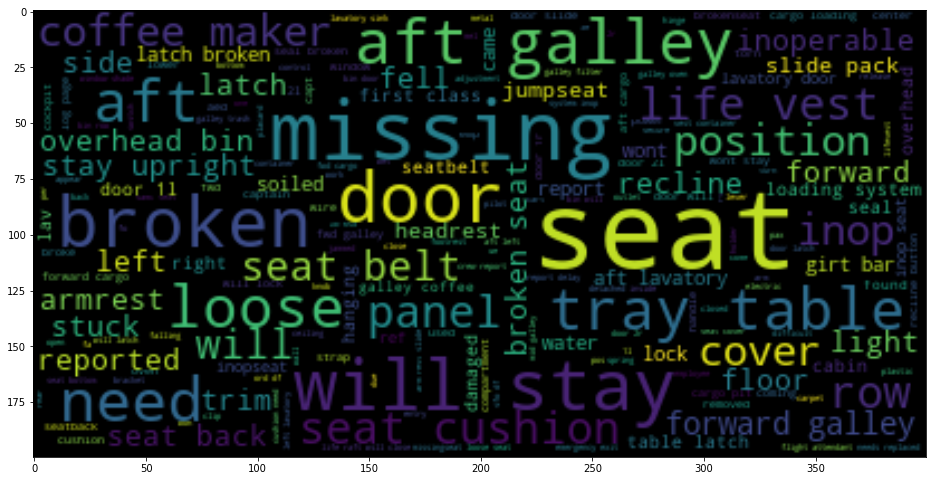

In [15]:
# https://medium.com/coinmonks/multi-label-classification-blog-tags-prediction-using-nlp-b0b5ee6686fc
totalText=''
for x in processed_data['problem_log']:
    totalText=totalText+x
from wordcloud import WordCloud
wc=WordCloud(background_color='black',max_font_size=50).generate(totalText)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation='bilinear')

### Build Wordcloud for corrective action

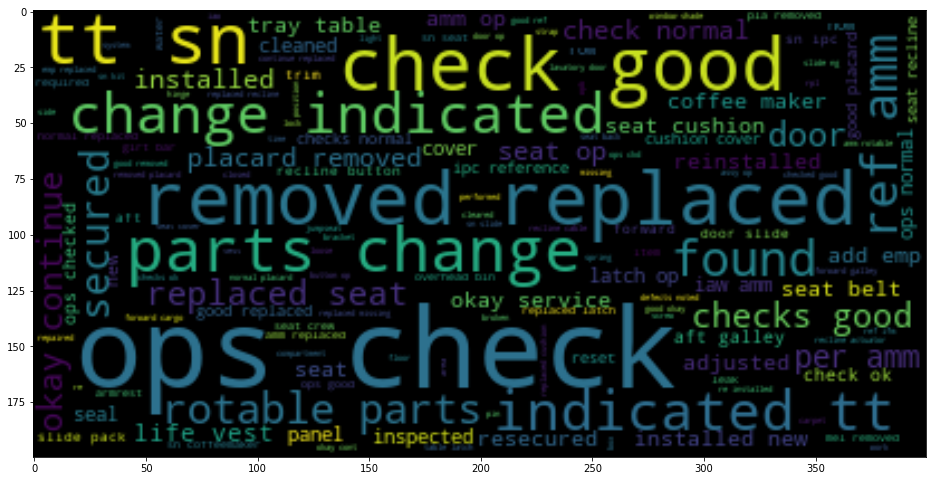

In [16]:
totalText=''
for x in processed_data['corrective_action']:
    totalText=totalText+x
from wordcloud import WordCloud
wc=WordCloud(background_color='black',max_font_size=50).generate(totalText)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation='bilinear')

### Save processed data to csv file

In [17]:
processed_data.to_csv('./data/processed_data_new.csv')